In [65]:
# <examples/doc_model_two_components.py>
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import PowerLawModel, ExponentialModel
from lib.to_precision import to_precision
import lmfit
from sympy import *
import sympy
from sympy.solvers import solve
from sympy import Symbol
import math
import datetime
from ipywidgets import interact, FloatText, IntText
now = lambda: str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").split(".")[0]

[[1.0000e+07 1.0000e+01 1.0000e+00]
 [1.0000e+08 3.0000e+01 1.0000e+00]
 [9.4506e+08 5.5000e+01 1.0000e+00]
 [1.0000e+09 6.0000e+01 1.0000e+00]
 [3.1700e+09 6.9000e+01 1.0000e+00]
 [6.5800e+09 8.3000e+01 1.0000e+00]
 [8.1500e+09 8.9000e+01 1.0000e+00]
 [8.2000e+09 9.0000e+01 1.0000e+00]
 [8.4600e+09 9.1000e+01 1.0000e+00]
 [8.7900e+09 9.2000e+01 1.0000e+00]
 [9.0400e+09 9.3000e+01 1.0000e+00]
 [9.2900e+09 9.4000e+01 1.0000e+00]
 [9.5800e+09 9.5000e+01 1.0000e+00]
 [1.0000e+10 1.0100e+02 1.0000e+00]
 [1.0800e+10 1.0100e+02 1.0000e+00]
 [1.1240e+10 1.0200e+02 1.0000e+00]
 [1.3310e+10 1.0300e+02 1.0000e+00]
 [1.8170e+10 1.0500e+02 1.0000e+00]
 [1.9220e+10 1.0600e+02 1.0000e+00]
 [2.0950e+10 1.0700e+02 1.0000e+00]
 [2.5610e+10 1.0900e+02 1.0000e+00]
 [2.7330e+10 1.1000e+02 1.0000e+00]
 [3.3820e+10 1.1300e+02 1.0000e+00]
 [5.4000e+10 1.2400e+02 1.0000e+00]
 [5.6980e+10 1.2500e+02 1.0000e+00]
 [5.8440e+10 1.2600e+02 1.0000e+00]
 [6.1550e+10 1.2700e+02 1.0000e+00]
 [6.3210e+10 1.2800e+02 1.00

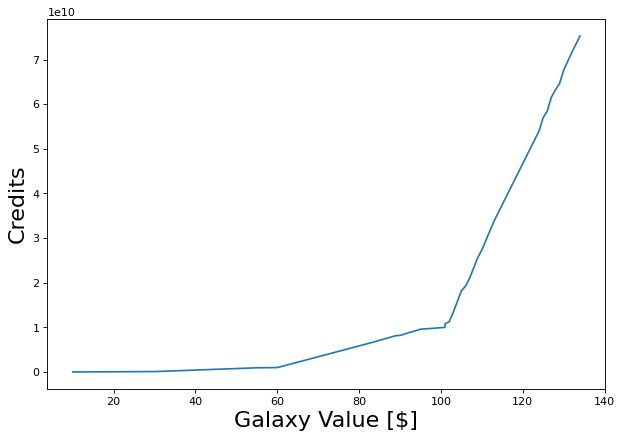

32


In [2]:
upper= 0
lower= 0
string = "dataset_1" #ohne_masse_differenz_winkelmass, MESSWERTE
data = np.genfromtxt(string+".txt", skip_header = lower*10, skip_footer = upper*10)
#data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)
print(data)
x = data[:,1]
x_err = data[:, 2]
y = data[:, 0]
#y_err = data[:, 2]
fig = plt.figure(figsize=(9,6), dpi=80)
plt.plot(x,y)
plt.ylabel(r"Credits", fontsize=20)
plt.xlabel(r"Galaxy Value [\$]", fontsize=20)
plt.show()
fig.savefig(string + "_Plot.pdf")
print(len(x))

In [3]:
def func1(x, a1,b1,c1, d1):#,b1
    return b1*np.exp(x/a1) + d1
def func2(x, a,b):#,b, c *293
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return a*(np.exp(1.602*10**(-19)*(x)/(1.38*10**(-23)*293))-1)
# def func3(x, amp3, cen3, wid3):#
#     """1-d gaussian: gaussian(x, amp, cen, wid)"""
#     return (amp3 / (sqrt(2*pi) * wid3)) * exp(-(x-cen3)**2 / (2*wid3**2))
# def func4(x, amp4, cen4, wid4):#
#     """1-d gaussian: gaussian(x, amp, cen, wid)"""
#     return (amp4 / (sqrt(2*pi) * wid4)) * exp(-(x-cen4)**2 / (2*wid4**2))
# def func5(x, amp5, cen5, wid5):#
#     """1-d gaussian: gaussian(x, amp, cen, wid)"""
#     return (amp5 / (sqrt(2*pi) * wid5)) * exp(-(x-cen5)**2 / (2*wid5**2))
# def func6(x, amp6, cen6, wid6):#
#     """1-d gaussian: gaussian(x, amp, cen, wid)"""
#     return (amp6 / (sqrt(2*pi) * wid6)) * exp(-(x-cen6)**2 / (2*wid6**2))
# #3_2 : 1/(1+1/(x**2*amp**2*(10**(-7))**2))**(1/2)
# #3_1 : 1/(1+(x**2*amp**2*cen**2))**(1/2)

# def funca(x):
#     """a line"""
#     return 0*x

In [4]:
mod = PowerLawModel()# + Model(func3)+ Model(func4)+ Model(func5)+ Model(func6)+Model(funca)
pars = mod.make_params(a1=1,b1=200, d1 = 80, c1 = 10,a=1, b=300, c=1000, amp=20, cen =300, wid=300, amp2 = 20, cen2 = -17, wid2=1, amp3=20, cen3 = 0, wid3=1, amp4=20, cen4 = 20, wid4=1, amp5=20, cen5 = 40, wid5=1, amp6=20, cen6=-49, wid6=1)#, cen=1, slope=0, intercept=1)

In [5]:
result = mod.fit(y, pars, x=x)
print(result.fit_report())

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 306
    # data points      = 32
    # variables        = 2
    chi-square         = 1.9270e+20
    reduced chi-square = 6.4234e+18
    Akaike info crit   = 1387.74226
    Bayesian info crit = 1390.67373
    R-squared          = 0.99026874
[[Variables]]
    amplitude:  0.02081656 +/- 0.01722754 (82.76%) (init = 1)
    exponent:   5.91844934 +/- 0.17102372 (2.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -0.9999


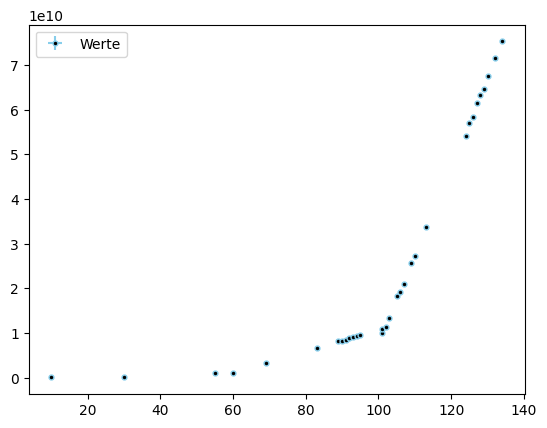

In [6]:
# plt.plot(x, result.init_fit, 'k--', label='initial fit')
# plt.plot(x, result.best_fit, 'r-', label='best fit')
plt.errorbar(y = y, yerr = 0, x = x, xerr = 0, \
             fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
             label = r'Werte')
plt.legend(loc='best')
plt.show()

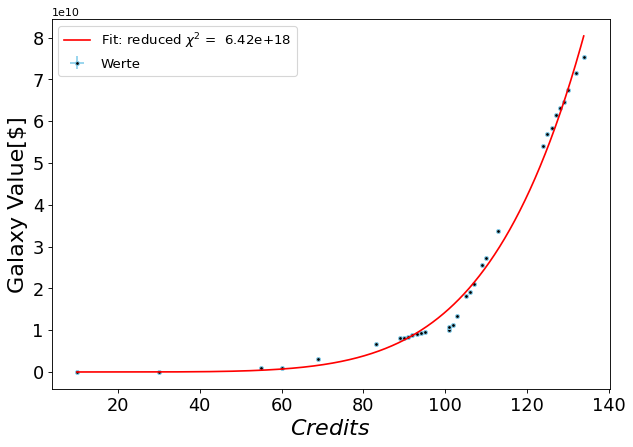

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{bilder/dataset_1_Plot20241015_070730.pdf} 
	\caption{dataset_1, Plot} 
 	\label{fig:dataset_1, Plot} 
\end{figure}


In [7]:
fig = plt.figure(figsize=(9,6), dpi=80)
dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
#plt.plot(x, y, 'skyblue')
plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
plt.errorbar(y = y, yerr = 0, x = x, xerr = 0, \
             fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
             label = r'Werte')
plt.legend(loc='best')

plt.ylabel(r"Galaxy Value[\$]", fontsize=20)
plt.xlabel(r"$Credits$ ", fontsize=20)

plt.legend(fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

fig.savefig(string + "_Plot" + str(now()) +".pdf")
plt.show()

string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + string + "_Plot" + str(now()) +".pdf} \n" \
    + "\t\\caption{"+str(string)+", Plot} \n \t\\label{fig:"+str(string)+", Plot} \n\end{figure}"
print(string_fig)

NameError: name 'y_err' is not defined

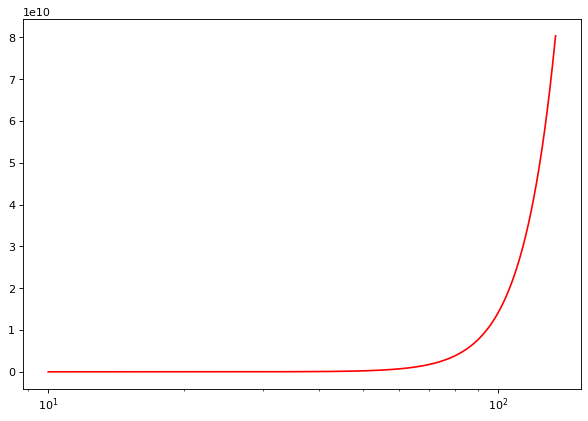

In [8]:
dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))

fig1, ax = plt.subplots(figsize=(9,6), dpi=80)
ax.set_xscale('log')
ax.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
#ax.plot(x, result.best_fit, 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
ax.errorbar(y = y, yerr = y_err, x = x, xerr = 0, \
             fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
             label = r'Werte')
ax.legend(loc='best')

plt.ylabel(r"$\frac{U_a}{U_e}$", fontsize=20)
plt.xlabel(r"$\omega$ [Hz]", fontsize=20)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(string + "_Plot_log.pdf")
plt.show()

string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + string + "_Plot_log.pdf} \n" \
    + "\t\\caption{"+str(string)+", Plot_log} \n \t\\label{fig:"+str(string)+", Plot_log} \n\end{figure}"
print(string_fig)


In [9]:
from ipywidgets import interact, fixed

In [79]:
class Data:
    __x = []
    __y = []
    __xerr = 0
    __yerr = 0
    __XName = "x"
    __YName = "y"
    def set_x(self, x):
        self.__x = x
        return  
    def set_y(self, x):
        self.__y = x
        return  
    def set_yerr(self, x):
        self.__yerr = x
        return  
    def set_xerr(self, x):
        self.__xerr = x
        return  
    
    def get_x(self):
        return self.__x
    def get_y(self):
        return self.__y
    def get_xerr(self):
        return self.__xerr
    def get_yerr(self):
        return self.__yerr
    
    def set_XName(self, x):
        self.__XName = rf"{x}"
        return
    def set_YName(self, x):
        self.__YName = rf"{x}"
        return
    def get_XName(self):
        return self.__XName
    def get_YName(self):
        return self.__YName


def import_Data(Datei:str="dataset_1", x_err_bool = False, y_err_bool = False, Daten=Data(), skip_lower:int=0, skip_upper:int=0, x_name:str="x", y_name:str="y"):
    data = np.genfromtxt(string+".txt", skip_header = skip_lower, skip_footer = skip_upper)
    #data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)
    
    if x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(data[:, 3])
    elif x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(0)
    elif not x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(data[:, 2])
    elif not x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(0)
    
    Daten.set_XName(x_name)
    Daten.set_YName(y_name)
    global fig1, ax
    fig1, ax = plt.subplots(figsize=(9,6), dpi=80)

    ax.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    plt.legend(loc='best')
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()

    
Daten = Data()

interact(import_Data, Datei="dataset_1", x_err_bool = False, y_err_bool = False, x_name = "x", y_name = "y", Daten=fixed(Daten), 
         skip_lower = IntText(value=0, step=1),
         skip_upper = IntText(value=0, step=1),
         )
print()

interactive(children=(Text(value='dataset_1', description='Datei'), Checkbox(value=False, description='x_err_b…

In [85]:

plt.savefig(string + "_Plot.pdf")


string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + string + "_Plot.pdf} \n" \
    + "\t\\caption{"+str(string)+", Plot_log} \n \t\\label{fig:"+str(string)+", Plot_log} \n\end{figure}"
print(string_fig)

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{bilder/dataset_1_Plot.pdf} 
	\caption{dataset_1, Plot_log} 
 	\label{fig:dataset_1, Plot_log} 
\end{figure}


<Figure size 640x480 with 0 Axes>

In [51]:
mod = PowerLawModel()
pars = mod.make_params()
pars

name,value,initial value,min,max,vary
amplitude,1.00000000,None,-inf,inf,True
exponent,1.00000000,None,-inf,inf,True


In [58]:


def update_model(**params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value

    # Berechne Modell mit aktuellen Parametern
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    plt.show()

param_widgets = {}
for param_name, param in pars.items():
    param_widgets[param_name] = FloatText(value=param.value,
                                            step=0.1,
                                            description=param_name)

# Interaktive Anzeige mit automatisch generierten Slidern
interact(update_model, **param_widgets)
print()

interactive(children=(FloatText(value=0.9, description='amplitude', step=0.1), FloatText(value=0.2, descriptio…